In [1]:
# import needed packages
%matplotlib inline
import numpy as np, matplotlib.pylab as plt, seaborn as sns, mpmath as mp, scipy.special as ss, sys
sys.path.append('os.getcwd()')
import geopandas as gp, pandas as pd, urllib2
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import os
import datetime
import pickle
from pdf_ccdf import pdf_ccdf
from pdf_functions import pdf_fitter as pdf_fitter
from a_b_functions import kirchner_fitter as kirchner_fitter, KirchnerBinning
from IRA_functions import assess_IRA as assess_IRA
from a_b_functions import getFlow as getFlow
import a_b_functions
import warnings
warnings.filterwarnings("ignore")

In [13]:
# Setup sitelist (by USGS gage id) and seasons for extraction
flow_files = a_b_functions.getFlowFileList()
site_data = gp.read_file('./USGS_Streamgages-NHD_Locations.shp')
# seasons = ['spring', 'summer', 'fall', 'winter', 'wet']
seasons = ['spring']
datedict = {}
A = {}
B = {}
P = {}
B_pdf = {}
nu_pdf = {}

dates = []

for fh in flow_files:
    site = fh.split('/')[-1][:8]
#     weather = pickle.load( open('./daymet_newman/'+site+'_daymet.p', 'rb') )
    df = pd.read_csv(fh, delim_whitespace=True, header=-1)
    df.columns = ['gagenum', 'Year', 'Month', 'Day', 'q', 'e']
    df['date'] = df[['Year', 'Month', 'Day']].apply(lambda s : datetime.datetime(*s),axis = 1)
    df = df[['q', 'date']]
    df.set_index('date', inplace=True)
    df['date'] = df.index
    df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
    df.q *= 2.447e9 #cm^3/day
    area = float(site_data['DA_SQ_MILE'].loc[site_data.SITE_NO==site])*2.58998811e10 #cm^2
    df.q = df.q/area # cm/day
    df = df.loc[df.q>0]
    
    for ind in range(len(seasons)):
        if seasons[ind]=='winter':
            tw = len(pd.date_range('12-2015', '3-2016'))
            d = df.q.loc[(df.index.month>=12)|(df.index.month<=2)]
        elif seasons[ind]=='spring': 
            tw = len(pd.date_range('3-2016', '6-2016'))
            d = df.q.loc[(df.index.month>=3)&(df.index.month<=5)]
        elif seasons[ind]=='summer':
            tw = len(pd.date_range('6-2016', '9-2016'))
            d = df.q.loc[(df.index.month>=6)&(df.index.month<=8)]
        elif seasons[ind]=='fall':
            tw = len(pd.date_range('9-2016', '12-2016'))
            d = df.q.loc[(df.index.month>=9)&(df.index.month<=11)]
        elif seasons[ind]=='wet':
            tw = len(pd.date_range('11-2016', '4-2017'))
            d = df.q.loc[(df.index.month>=11)|(df.index.month<=4)]

        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

        A_hat, B_hat, P_hat, dateList = kirchner_fitter(d, ax=ax1)
        A[(site, seasons[ind])] = A_hat
        B[(site, seasons[ind])] = B_hat
        P[(site, seasons[ind])] = P_hat
        datedict[(site, seasons[ind])] = dateList

        # pdf_fitter needs a numnpy array of all daily discharge magnitudes in timeseries. If you pass it an axis, it will plot pdf of sample against best fit. 
#         sample = pd.DataFrame({'q':d.tolist()}).q
#         B_pdf_hat, nu_hat = pdf_fitter(sample, ax=ax2)
#         B_pdf[(site, seasons[ind])] = B_pdf_hat
#         nu_pdf[(site, seasons[ind])] = nu_hat

NameError: name 'ax1' is not defined

In [2]:
def run_newman(fh):
    A = {}
    B = {}
    P = {}
    R2_arr = {}
    R2_storage = {}
    B_pdf = {}
    nu_pdf = {}
    datedict = {}
    MU_E = {}
    LAM_H = {}
    ALPHA_H = {}
    MU_KT = {}
    MU_T = {}
    NU_K = {}
    NU_K_BSE = {}
    R2_ARR = {}
    R2_STORAGE = {}
    R2B = {}
    R2B_K = {}

    site = fh.split('/')[-1][:8]
    weather = pickle.load( open('./daymet_newman/'+site+'_daymet.p', 'rb') )
    df = pd.read_csv(fh, delim_whitespace=True, header=-1)
    df.columns = ['gagenum', 'Year', 'Month', 'Day', 'q', 'e']
    df['date'] = df[['Year', 'Month', 'Day']].apply(lambda s : datetime.datetime(*s),axis = 1)
    df = df[['q', 'date']]
    df.set_index('date', inplace=True)
    df['date'] = df.index
    df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
    df.q *= 2.447e9 #cm^3/day
    area = float(site_data['DA_SQ_MILE'].loc[site_data.SITE_NO==site])*2.58998811e10 #cm^2
    df.q = df.q/area # cm/day
    df = df.loc[df.q>0]
    
    for ind in range(len(seasons)):
        if seasons[ind]=='winter':
            tw = len(pd.date_range('12-2015', '3-2016'))
            d = df.q.loc[(df.index.month>=12)|(df.index.month<=2)]
        elif seasons[ind]=='spring': 
            tw = len(pd.date_range('3-2016', '6-2016'))
            d = df.q.loc[(df.index.month>=3)&(df.index.month<=5)]
        elif seasons[ind]=='summer':
            tw = len(pd.date_range('6-2016', '9-2016'))
            d = df.q.loc[(df.index.month>=6)&(df.index.month<=8)]
        elif seasons[ind]=='fall':
            tw = len(pd.date_range('9-2016', '12-2016'))
            d = df.q.loc[(df.index.month>=9)&(df.index.month<=11)]
        elif seasons[ind]=='wet':
            tw = len(pd.date_range('11-2016', '4-2017'))
            d = df.q.loc[(df.index.month>=11)|(df.index.month<=4)]

        
        fig, axes = plt.subplots(3,2, figsize=(10,12))
        
        A_hat, B_hat, P_hat, dateList = kirchner_fitter(d, ax=axes[0,0])
        A[(site, seasons[ind])] = A_hat
        B[(site, seasons[ind])] = B_hat
        P[(site, seasons[ind])] = P_hat
        datedict[(site, seasons[ind])] = dateList
         

        # pdf_fitter needs a numnpy array of all daily discharge magnitudes in timeseries. If you pass it an axis, it will plot pdf of sample against best fit. 
        sample = pd.DataFrame({'q':d.tolist()}).q
        sample = sample[1:500]
        MU_E[(site, seasons[ind])] = sample.mean()
        B_pdf_hat, nu_hat, B_pdf_bse, nu_bse, mu_t, r2b = pdf_fitter(sample, ax=axes[0,1])
        B_whatever, nu_k, B_junk, nu_k_bse, mu_kt, r2b_k = pdf_fitter(sample, ax=axes[0,1], b=B_hat)
        
        MU_KT[(site, seasons[ind])] = mu_kt
        MU_T[(site, seasons[ind])] = mu_t
        B_pdf[(site, seasons[ind])] = B_pdf_hat
        nu_pdf[(site, seasons[ind])] = nu_hat
        jump_df, arrivals, storage_mags, r2_arr, r2_storage = assess_IRA(d, A_hat, B_hat, tw=tw, axs=(axes.flatten())[2:])
        R2_ARR[(site, seasons[ind])] = r2_arr
        R2_STORAGE[(site, seasons[ind])] = r2_storage
        LAM_H[(site, seasons[ind])] = np.mean(arrivals)
        ALPHA_H[(site, seasons[ind])] = np.mean(storage_mags)
        NU_K[(site, seasons[ind])] = nu_k
        NU_K_BSE[(site, seasons[ind])] = nu_k_bse
        R2B[(site, seasons[ind])] = r2b
        R2B_K[(site, seasons[ind])] = r2b_k
        
        savestr = site + '_' + seasons[ind] + '.png'
        fig.savefig('./plots/'+savestr)
    return (A, B, datedict, B_pdf, nu_pdf, r2_arr, r2_storage, MU_E, LAM_H, ALPHA_H, NU_K, NU_K_BSE, MU_KT, MU_T, R2B, R2B_K)



flow_files = a_b_functions.getFlowFileList()
site_data = gp.read_file('./USGS_Streamgages-NHD_Locations.shp')
# seasons = ['spring', 'summer', 'fall', 'winter', 'wet']
seasons = ['spring', 'fall']

from math import sqrt
from joblib import Parallel, delayed
res = Parallel(n_jobs=2)(delayed(run_newman) (flow_files[i]) for i in range(len(flow_files)))
pickle.dump(res, open('./results.p', 'wb'))

Optimization terminated successfully.
         Current function value: 0.752823
         Iterations: 43
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: 0.559996
         Iterations: 43
         Function evaluations: 87
Optimization terminated successfully.
         Current function value: 0.768275
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.594312
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.756585
         Iterations: 42
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: 0.527432
         Iterations: 45
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 0.774126
         Iterations: 19
         Function evaluations: 38
Optimization terminated successful

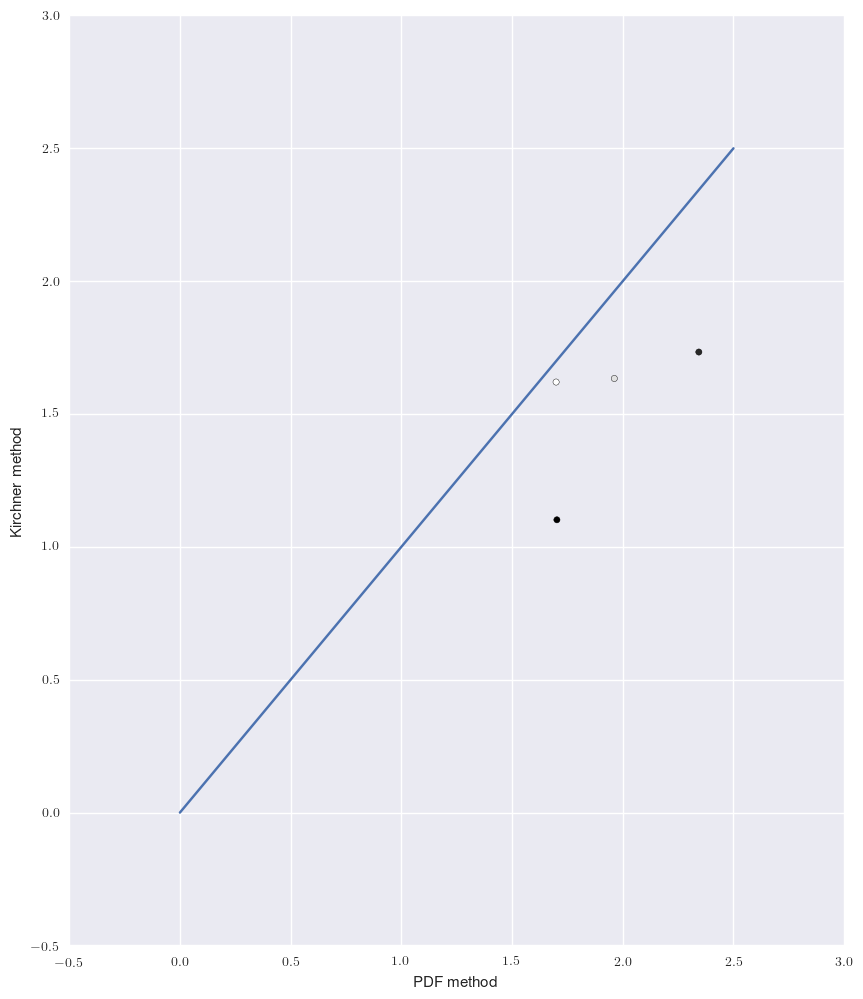

In [21]:
A = {}
B = {}
P = {}
R2_arr = {}
R2_storage = {}
B_pdf = {}
nu_pdf = {}

for entry in res: 
    (Atemp, Btemp, datedicttemp, B_pdftemp, nu_pdftemp, r2_arrtemp, r2_storagetemp) = entry
    A.update(Atemp)
    B.update(Btemp)
    datedict.update(datedicttemp)
    B_pdf.update(B_pdftemp)
    nu_pdf.update(nu_pdftemp)
    R2_arr.update(r2_arrtemp)
    R2_storage.update(r2_storagetemp)

bpdf = []
bkirchner = []
nulist = []

for key in B.keys():
    bpdf.append(B_pdf[key])
    bkirchner.append(B[key])
    nulist.append(nu_pdf[key])
f, ax = plt.subplots(1, figsize=(10,12))
plt.scatter(bpdf, bkirchner, c=nulist)
plt.plot([0,2.5], [0,2.5])
plt.xlabel('PDF method')
plt.ylabel('Kirchner method')